In [ ]:
# COMP 548 - MEDICAL IMAGE ANALYSIS HOMEWORK #2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable

import torchvision
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage
from torchvision.io import read_image

import torch.utils.data
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

import numpy as np

import os

import matplotlib.pyplot as plt

from PIL import Image

import copy

import multiprocessing as mp

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

mp.set_start_method('spawn', force=True)

In [ ]:
training_dataset_dir = '.../path/...'
test_dataset_dir = '.../path/...'

training_label_file = '.../path/...'
test_label_file = '.../path/...'

In [ ]:
img_dir = '.../path/...'
label_file = '.../path/...'

img_names = os.listdir(img_dir)
img_names.sort()

with open(label_file, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

if len(img_names) != len(labels):
    print(f"Mismatch between - {len(img_names)} images vs {len(labels)} labels")
else:
    print("Matched!")

Matched!


In [ ]:
class my_dataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.img_names.sort()
        self.labels = []
        with open(label_file, 'r') as f:
            self.labels = [int(line.strip()) for line in f.readlines()]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_name

In [ ]:
transformations = Compose([Resize((224, 224)),
                           ToTensor(),
                          #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           ])

In [ ]:
train_dataset = my_dataset(img_dir=training_dataset_dir,
                          label_file=training_label_file,
                          transform=transformations)

test_dataset = my_dataset(img_dir=test_dataset_dir,
                          label_file=test_label_file,
                          transform=transformations)

In [ ]:
batch_size=4

In [ ]:
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def class_labels(dataset):
  labels = []
  for _, label, _ in dataset:
    labels.append(label)
  return labels


def plot_class_distribution(labels, title):
    plt.figure(figsize=(8, 4))
    plt.hist(labels, bins=range(min(labels), max(labels) + 2), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(range(min(labels), max(labels) + 1))
    plt.grid(True)
    plt.show()

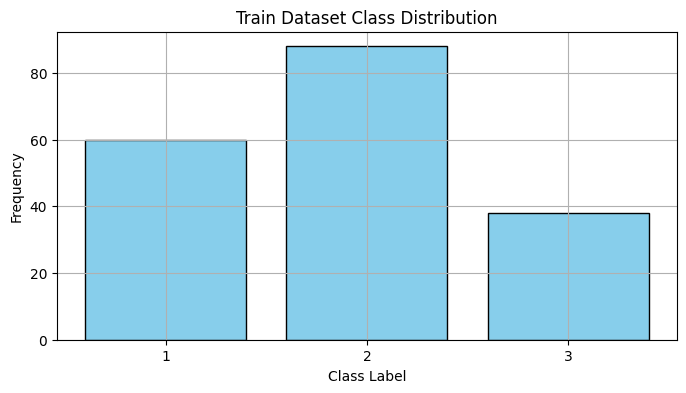

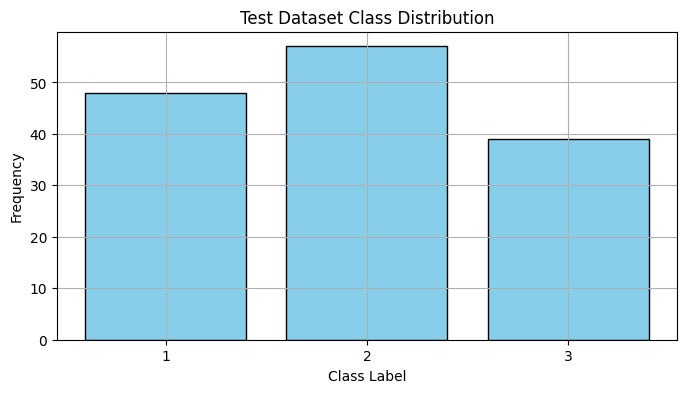

In [ ]:
train_labels = class_labels(train_dataset)
test_labels = class_labels(test_dataset)

plot_class_distribution(train_labels, 'Train Dataset Class Distribution')
plot_class_distribution(test_labels, 'Test Dataset Class Distribution')

In [ ]:
# KFOLD v4

class Trainer:
    def __init__(self, model, loss_func, learning_rate=0.001, num_classes=3, save_path='model.pth', n_splits=5, class_weights=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.loss_func = loss_func
        self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)
        self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.4)
        self.num_classes = num_classes
        self.save_path = save_path
        self.n_splits = n_splits
        self.best_val_accuracy = 0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
            self.loss_func = nn.CrossEntropyLoss(weight=self.class_weights)

    def run_phase(self, loader, training=False):
        mode = 'train' if training else 'eval'
        self.model.train(mode == 'train')
        correct, total = 0, 0
        total_loss = 0.0
        all_labels, all_preds = [], []

        with torch.set_grad_enabled(training):
            for inputs, labels, _ in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                labels -= 1  # maybe revise the mydataset class to get rid of this extra line?
                outputs = self.model(inputs)
                loss = self.loss_func(outputs, labels)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                total_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                if training:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

        self.scheduler.step()

        average_loss = total_loss / total
        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
        recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
        return average_loss, accuracy, precision, recall

    def train(self, dataset, batch_size=4, num_epochs=10):
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            train_subsampler = Subset(dataset, train_idx)
            val_subsampler = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

            print(f"\nStarting fold {fold + 1}/{self.n_splits}")
            for epoch in range(num_epochs):
                train_loss, train_accuracy, train_precision, train_recall = self.run_phase(train_loader, training=True)
                val_loss, val_accuracy, val_precision, val_recall = self.run_phase(val_loader, training=False)

                print(f"Epoch {epoch + 1}/{num_epochs} - Fold {fold + 1}/{self.n_splits}")
                print(f"Training Loss  : {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}%")
                print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}%")
                print("")
                print(f"Training - Class 1: Precision: {train_precision[0]:.4f}, Recall: {train_recall[0]:.4f}")
                print(f"Training - Class 2: Precision: {train_precision[1]:.4f}, Recall: {train_recall[1]:.4f}")
                print(f"Training - Class 3: Precision: {train_precision[2]:.4f}, Recall: {train_recall[2]:.4f}")
                print("")
                print(f"Validation - Class 1: Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}")
                print(f"Validation - Class 2: Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}")
                print(f"Validation - Class 3: Precision: {val_precision[2]:.4f}, Recall: {val_recall[2]:.4f}")
                print(f"Overall Training Accuracy: {train_accuracy:.4f}%")
                print(f"Overall Validation Accuracy: {val_accuracy:.4f}%")

                if val_accuracy > self.best_val_accuracy:
                    self.best_val_accuracy = val_accuracy
                    self.best_model_wts = copy.deepcopy(self.model.state_dict())
                    print(f"New best model found with {val_accuracy:.4f}% accuracy on validation.")

        # Retrain model on the entire dataset with the best model weights
        self.model.load_state_dict(self.best_model_wts)
        self.model.train()
        full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        total_loss, total_accuracy, total_precision, total_recall = 0, 0, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]
        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_precision, train_recall = self.run_phase(full_loader, training=True)
            total_loss += train_loss
            total_accuracy += train_accuracy
            for i in range(3):
                total_precision[i] += train_precision[i]
                total_recall[i] += train_recall[i]

        # Mean metrics
        mean_loss = total_loss / num_epochs
        mean_accuracy = total_accuracy / num_epochs
        mean_precision = [p / num_epochs for p in total_precision]
        mean_recall = [r / num_epochs for r in total_recall]

        print(f"Training Loss: {train_loss:.4f} | Mean Overall Accuracy: {mean_accuracy:.4f}%")
        for i in range(3):
            print(f"Class {i+1} - Mean Precision: {mean_precision[i]:.4f}, Mean Recall: {mean_recall[i]:.4f}")

        torch.save(self.model.state_dict(), self.save_path)
        print(f"Final model retrained and saved to {self.save_path}")

    def test(self, test_loader):
        self.model.load_state_dict(torch.load(self.save_path))
        self.model.eval()
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                labels -= 1 # maybe revise the mydataset class to get rid of this extra line?
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        if len(all_labels) > 0 and len(all_preds) > 0:
            precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
            recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
            overall_accuracy = accuracy_score(all_labels, all_preds) * 100
            metrics = {
                'precision': precision,
                'recall': recall,
                'overall_accuracy': overall_accuracy}

        print("Test Metrics:")
        print(f"Overall Test Accuracy: {metrics['overall_accuracy']:.4f}%")
        for i, (prec, rec) in enumerate(zip(metrics['precision'], metrics['recall']), start=1):
            print(f"Class {i} - Precision: {prec:.4f}, Recall: {rec:.4f}")
        return metrics


    def calculate_metrics(self, labels, preds):
        precision = precision_score(labels, preds, average=None, zero_division=0)
        recall = recall_score(labels, preds, average=None, zero_division=0)
        overall_accuracy = np.mean(labels == preds) * 100
        return {'precision': precision, 'recall': recall, 'overall_accuracy': overall_accuracy}

In [ ]:
def model_loader(model, model_type):
    for param in model.parameters():
        param.requires_grad = False

    if model_type == 'AlexNet':
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 3)
    elif model_type == 'ResNet':
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)
    elif model_type == 'MobileNetV2':
        model.classifier[1] = nn.Linear(model.last_channel, 3)
    return model


models_to_test = [{'model': model_loader(models.alexnet(pretrained=True), 'AlexNet'), 'name': 'AlexNet'},
                  {'model': model_loader(models.resnet18(pretrained=True), 'ResNet'), 'name': 'ResNet18'},
                  {'model': model_loader(models.mobilenet_v2(pretrained=True), 'MobileNetV2'), 'name': 'MobileNetV2'}]

def model_picker(models_to_test, train_dataset, test_dataloader):
    for model_dict in models_to_test:
        model = model_dict['model'].cuda() if torch.cuda.is_available() else model_dict['model']
        model_name = model_dict['name']
        print("Training", model_name)
        save_path = f'/content/drive/MyDrive/COMP 548 - MED IMG/Assignments/Assignment 2/{model_name}_model.pth'

        # Class weights
        labels = [label for _, label, _ in train_dataset]
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

        trainer = Trainer(model, nn.CrossEntropyLoss(), 0.001, 3, save_path, n_splits=3, class_weights=class_weights)
        trainer.train(train_dataset, num_epochs=2)
        metrics = trainer.test(test_dataloader)
        # Metric calculation
        model_dict['overall_accuracy'] = metrics['overall_accuracy']

    # Find the best model
    best_model_dict = max(models_to_test, key=lambda x: x.get('overall_accuracy', 0))
    print(f"Best Model: {best_model_dict['name']} with Overall Test Accuracy: {best_model_dict['overall_accuracy']:.4f}%")
    return best_model_dict['model'], best_model_dict['name']

best_model, best_model_name = model_picker(models_to_test, train_dataset, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weight

Training AlexNet

Starting fold 1/3
Epoch 1/2 - Fold 1/3
Training Loss: 1.1612 | Training Accuracy: 55.65%
Validation Loss: 0.9957 | Validation Accuracy: 61.29%

Training - Class 1: Precision: 0.4118, Recall: 0.3590
Training - Class 2: Precision: 0.6984, Recall: 0.7333
Training - Class 3: Precision: 0.4074, Recall: 0.4400

Validation - Class 1: Precision: 1.0000, Recall: 0.0476
Validation - Class 2: Precision: 0.6222, Recall: 1.0000
Validation - Class 3: Precision: 0.5625, Recall: 0.6923
Overall Training Accuracy: 55.65%
Overall Validation Accuracy: 61.29%
New best model found with 61.29% accuracy on validation.
Epoch 2/2 - Fold 1/3
Training Loss: 0.7200 | Training Accuracy: 70.97%
Validation Loss: 0.7601 | Validation Accuracy: 66.13%

Training - Class 1: Precision: 0.6486, Recall: 0.6154
Training - Class 2: Precision: 0.7759, Recall: 0.7500
Training - Class 3: Precision: 0.6552, Recall: 0.7600

Validation - Class 1: Precision: 0.7143, Recall: 0.2381
Validation - Class 2: Precision: 0.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

model = models.alexnet(pretrained=True)

# Freeze the parameters (IMPORTANT !!!!!!!!)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)

loss = nn.CrossEntropyLoss()

save_path = '/content/drive/MyDrive/COMP 548 - MED IMG/Assignments/Assignment 2/comp548_assign2_alexnet_model.pth'

labels = [label for _, label, _ in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
trainer = Trainer(model, nn.CrossEntropyLoss(), 0.001, 3, save_path, n_splits=3, class_weights=class_weights)
trainer.train(train_dataset, batch_size, num_epochs=10)

# Testing the trained model
print("Testing Model:")
metrics = trainer.test(test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting fold 1/3
Epoch 1/10 - Fold 1/3
Training Loss  : 1.1000 | Training Accuracy: 51.6129%
Validation Loss: 1.5542 | Validation Accuracy: 51.6129%

Training - Class 1: Precision: 0.4615, Recall: 0.4615
Training - Class 2: Precision: 0.6667, Recall: 0.6000
Training - Class 3: Precision: 0.3226, Recall: 0.4000

Validation - Class 1: Precision: 0.0000, Recall: 0.0000
Validation - Class 2: Precision: 0.7500, Recall: 0.7500
Validation - Class 3: Precision: 0.3235, Recall: 0.8462
Overall Training Accuracy: 51.6129%
Overall Validation Accuracy: 51.6129%
New best model found with 51.6129% accuracy on validation.
Epoch 2/10 - Fold 1/3
Training Loss  : 1.0271 | Training Accuracy: 57.2581%
Validation Loss: 0.9813 | Validation Accuracy: 61.2903%

Training - Class 1: Precision: 0.4167, Recall: 0.3846
Training - Class 2: Precision: 0.7097, Recall: 0.7333
Training - Class 3: Precision: 0.4615, Recall: 0.4800

Validation - Class 1: Precision: 0.4848, Recall: 0.7619
Validation - Class 2: Precision: